In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Intro

The purpose of this notebook is to test a interim solution to automatic segmentation of whole-brain datasets into fascicle models. This interim solution uses freesurfer regions to get in the ballpark, then recobundles to clean up the results and pyAFQ to quantify the metrics along the track and AFQ browser to view the results.

In [60]:
import pandas as pd
import os
import dipy as dp
from dipy.tracking.utils import length
from dipy.tracking import utils
from glob import glob
import nibabel as nib
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nilearn.plotting as nip

from dipy.viz import window, actor, ui
from IPython.display import Image

# Use the Freesurfer to get in the ballpark

In [3]:
def loadnii(niipath):
    im = nib.load(niipath)
    return im, im.get_data(), im.affine

In [306]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg, hdrloaded

In [5]:
def filter_length(streamlines, minlen=40):
    print("calc lengths")
    lengths = list(length(streamlines))
    print("filter")
    long_sls = []
    for i,sl in enumerate(streamlines):
        if lengths[i] > minlen:
            long_sls.append(sl)
    return long_sls

In [6]:
def plotroi(data, aff, bg=None):
    nip.plot_roi(nib.Nifti1Image(1*(data), aff), bg_img=bg, cmap='magma')

In [7]:
def filter_freesurf(sls, apac_data, aff, code):
    return list(utils.target(sls, apac_data==code, affine=aff))

In [8]:
putdir = './pyAFQuicobundles_freesurfer_test_outputs'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [375]:
roi_matrix_path = 'WM_pathways_freesurfer_based_seg_EC_KMJmod.xlsx'

pathpath = '/Users/kesshijordan/paths/pyafquicobundles_freesurfer_test_basepath.txt'

with open(pathpath, 'r') as myfile:
    case_basepath = myfile.read().replace('\n', '').replace('\'','')

Load and unpack the streamlines and aparc+aseg file

In [273]:
apac_path = glob(os.path.join(case_basepath,'aparc+aseg_di*.nii*'))[0]
fa_path = glob(os.path.join(case_basepath, '*_fa.nii*'))[0]
md_path = glob(os.path.join(case_basepath, '*_md.nii*'))[0]
wb_path = glob(os.path.join(case_basepath, 'Whole_Brain*newapi.trk'))[0]

In [58]:
tg, hdr = loadtgm_newapi(wb_path)
sls = tg.streamlines
#Only keep streamlines greater than 40mm. We don't really trust shorter segments than this
long_sls = filter_length(sls) 

In [348]:
apac_im, apac_data, apac_aff = loadnii(apac_path)
fa_im, fa_data, fa_aff = loadnii(fa_path)
md_im, md_data, md_aff = loadnii(md_path)

In [376]:
roi_matrix = pd.read_excel(roi_matrix_path)

In [377]:
roi_matrix.head()

,VOIS,aparc+aseg,Left ASLANT,Left ARCUATE,Left SLF I,Left SLF II,Left SLF III,Left SLF tp,Left ILF,Left IFOF,...,Right SLF I,Right SLF II,Right SLF III,Right SLF tp,Right ILF,Right IFOF,Right Uncinate,Right MdLF,Right FRONTOCAUDATE,Right FRONTOPUTAMEN
0,ctx-lh-bankssts,1001,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ctx-lh-caudalanteriorcingulate,1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ctx-lh-caudalmiddlefrontal,1003,-1.0,2.0,NaN,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ctx-lh-cuneus,1005,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ctx-lh-entorhinal,1006,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


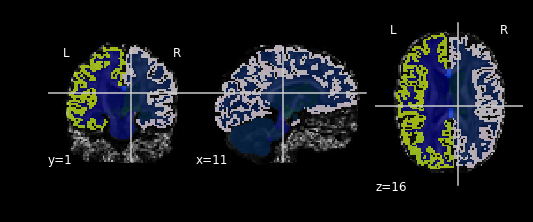

In [17]:
nip.plot_roi(apac_im, bg_img=fa_path)

In [18]:
def build_dict(track_name, roi_matrix):
    rois = roi_matrix[track_name]
    roi_groups = list(rois.value_counts().index)
    
    roi_dict = {}
    roi_dict['include'] = {}
    roi_dict['exclude'] = {}

    for i in roi_groups:
        if i>0:
            roitype = 'include'
        elif i<0:
            roitype = 'exclude'
        else:
            raise('UHOH')
        setname = 'set'+str(int(i))
        roi_dict[roitype][setname]={}

        temp=roi_matrix[rois==i]
        for j,name in enumerate(temp['VOIS']):
            roi_dict[roitype][setname][name] = temp['aparc+aseg'].values[j]
    return roi_dict

In [19]:
def combine_rois(mydict, apac):
    x,y,z = apac.shape
    include = np.zeros([x,y,z,len(mydict['include'])])
    exclude = np.zeros([x,y,z,len(mydict['exclude'])])
    for i,iset in enumerate(mydict['include'].keys()):
        for item in mydict['include'][iset].items():
            include[:,:,:,i] += 1*(apac==item[-1])
    for j,jset in enumerate(mydict['exclude'].keys()):
        for item in mydict['exclude'][jset].items():
            exclude[:,:,:,j] += 1*(apac==item[-1])
    return include, exclude

In [20]:
mydict = build_dict('Left ARCUATE', roi_matrix=roi_matrix)
include, exclude = combine_rois(mydict, apac_data)

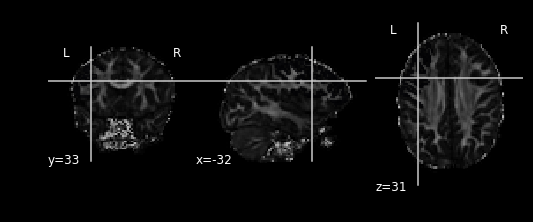

In [21]:
plotroi(include[:,:,:,0], fa_aff, fa_im)

In [104]:
def genren_AGG(sls, sls2=None, niidata=None, roi1=None, roi2=None, aff=np.eye(4), putpath='test.png', showme=False, showaxes=False):
    
    renderer = window.Renderer()
    
    renderer.set_camera(position=(-606.93, -153.23, 28.70),
                    focal_point=(2.78, 11.06, 15.66),
                    view_up=(0,0,1))
    
    
    stream_actor = actor.line(sls)
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=(1,1,1))
        renderer.add(stream_actor2)
    
    if roi1 is not None:
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
    if roi2 is not None:
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor2)
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)
    
    if showaxes:
        axes = actor.axes()
        renderer.add(axes)
    
    if showme:
        window.show(renderer, size=(500, 500), reset_camera=False)
    window.record(renderer, out_path=putpath, size=(500, 500))
    #renderer.camera_info()
    del renderer
    return putpath

In [23]:
def targetme(sls, include, exclude, aff):
    for i in range(include.shape[-1]):
        sls = list(utils.target(sls, include[:,:,:,i], affine=aff))
    for i in range(exclude.shape[-1]):
        sls = list(utils.target(sls, exclude[:,:,:,i], affine=aff, include=False))
    return sls
arc = targetme(long_sls, include, exclude, fa_aff)

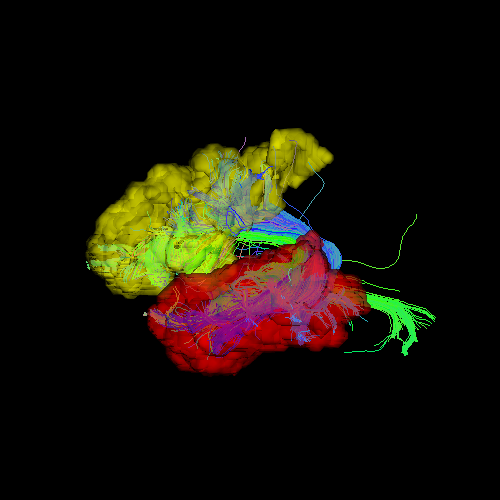

In [25]:
Image(genren_AGG(arc, aff=fa_aff, roi1=include[:,:,:,0], roi2=include[:,:,:,1]))

# Clean up result with Recobundles

In [26]:
from dipy.align.streamlinear import whole_brain_slr, slr_with_qb, transform_streamlines
from dipy.segment.clustering import qbx_and_merge
from dipy.segment.bundles import RecoBundles

In [27]:
def rough_reg(sub_fixed, temp_moving):
    #template moves to the subject space
    #qb_thr=5 errored
    moved, transform, qb_centroids1, qb_centroids2 = whole_brain_slr(sub_fixed, temp_moving, 
                                                                     verbose=True,
                                                                     progressive=True)
    return moved, transform, qb_centroids1, qb_centroids2

In [28]:
def run_rb(templatesls, bucketosls, cluster_map=None, pruning_thr=10):
    # try pruning thresh 10 if not specific drop to 5
    if cluster_map is None:
        cluster_map = qbx_and_merge(bucketosls, thresholds=[40, 25, 20, 10])
    else:
        print("Loading provided cluster map")

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=5)
    recognized_atlassp, rec_labels, recognized_ptsp = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10, pruning_thr=pruning_thr)
    '''rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=1.)'''
    #D = bundles_distances_mam(templatesls, recognized)
    
    return recognized_ptsp, cluster_map

In [29]:
template_basepath = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL'

In [30]:
wb_template = os.path.join(template_basepath, 'Whole_Brain_long_resaved_newapi.trk')
wb_template_tg, wb_template_hdr = loadtgm_newapi(wb_template)
wb_template_sls = wb_template_tg.streamlines

template_arcuate = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Arcuate_template.trk'
template_arcuate_tg, template_arcuate_hdr = loadtgm_newapi(template_arcuate)
template_arcuate_sls = template_arcuate_tg.streamlines

In [31]:
moved_temp2case, xfm_temp2case, qbc1_temp2pcase, qbc2_temp2case = rough_reg(long_sls[::10], wb_template_sls)

Static streamlines size 78638
Moving streamlines size 108379
Static streamlines after length reduction 63622
Moving streamlines after length reduction 91351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 258
QB moving centroids size 330
SLR finished in  9.584 seconds.
SLR iterations: 43 


In [32]:
template_arcuate_sls_xfmd = template_arcuate_tg.copy().apply_affine(xfm_temp2case).streamlines

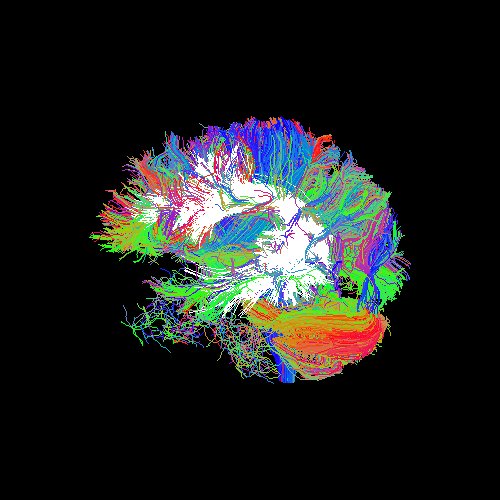

In [33]:
Image(genren_AGG(long_sls[::100], sls2=template_arcuate_sls_xfmd, putpath='test.png'), width=400,height=400)

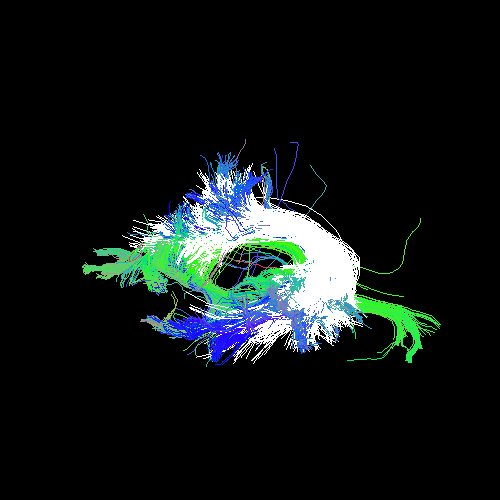

In [34]:
Image(genren_AGG(arc, sls2=template_arcuate_sls_xfmd, putpath='test.png'), width=400,height=400)

In [35]:
template_arrayseq = nib.streamlines.array_sequence.ArraySequence(template_arcuate_sls_xfmd)
bucket_arrayseq = nib.streamlines.array_sequence.ArraySequence(arc)

In [37]:
rb_arcuate, ig_ip = run_rb(template_arrayseq, bucket_arrayseq)

 Resampled to 20 points
 Size is 0.789 MB
 Duration of resampling is 0.013 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 3448 random streamlines
 Duration 0.071 sec. 

 Streamlines have 37 centroids
 Total loading duration 0.000 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 1039 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.238 MB
 Duration of resampling is 0.006 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.045 sec. 

 Model bundle has 114 centroids
 Duration 0.050 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 1854
 Duration 0.017 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.852
 Number of iterations 53
 Matrix size (4, 4)
[[ 0.946  0.066 -0.171  2.775]
 [-0.004  0.905  0.329 -5.146]
 [ 0.183 -0.322  0.889

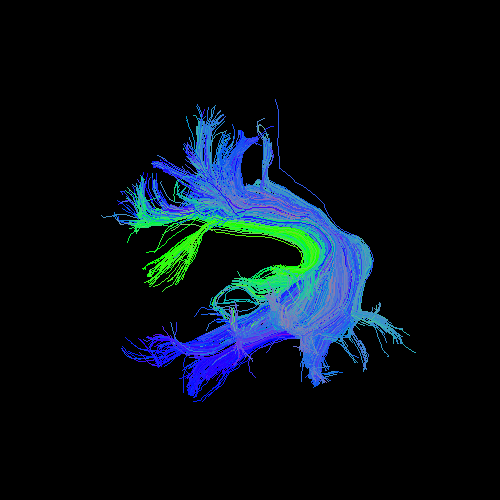

In [38]:
Image(genren_AGG(rb_arcuate, putpath='test.png'), width=400,height=400)

# AFQ

In [41]:
from AFQ.segmentation import calculate_tract_profile, gaussian_weights

In [47]:
profile_arcuate = calculate_tract_profile(fa_data, list(rb_arcuate), affine=fa_aff)

In [234]:
gweights = gaussian_weights(list(rb_arcuate))
profile_arcuate_gweights = calculate_tract_profile(fa_data, list(rb_arcuate), affine=fa_aff, weights=gweights)

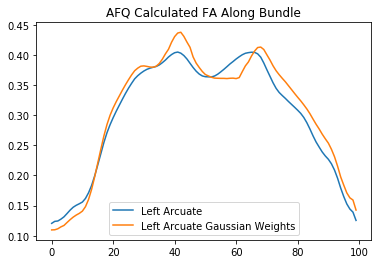

In [236]:
fig, ax = plt.subplots(1)
ax.plot(profile_arcuate, label='Left Arcuate')
ax.plot(profile_arcuate_gweights, label='Left Arcuate Gaussian Weights')
ax.set_title('AFQ Calculated FA Along Bundle')
ax.legend()

# Now batch it

In [378]:
from dipy.align.streamlinear import StreamlineLinearRegistration
from dipy.tracking.streamline import set_number_of_points

In [379]:
def runslr(fixed, moving, npts=20):
    fixed_subsamp = set_number_of_points(fixed, npts)
    moving_subsamp = set_number_of_points(moving, npts)
    
    srr = StreamlineLinearRegistration()
    srm = srr.optimize(static=fixed_subsamp, moving=moving_subsamp)
    aligned = srm.transform(moving)
    return aligned

In [380]:
pathpath_template = '/Users/kesshijordan/paths/child_single_subject_template_basepath.txt'

In [381]:
with open(pathpath_template, 'r') as myfile:
    template_basepath = myfile.read().replace('\n', '').replace('\'','')

In [307]:
template_list = os.listdir(os.path.join(template_basepath,'TRACKs'))

wb_template_child = glob(os.path.join(template_basepath, 'TRACKs/Whole*newapi.trk'))[0]

wb_template_child_tg, wb_template_child_hdr = loadtgm_newapi(wb_template_child)
backuptrk, backuphdr = nib.trackvis.read(wb_template_child)

wb_template_child_sls = wb_template_tg.streamlines

In [315]:
backuptrk, backuphdr = nib.trackvis.read(wb_template_child)

In [237]:
moved_temp2case_child, xfm_temp2case_child, qbc1_temp2pcase_child, qbc2_temp2case_child = rough_reg(long_sls[::10], wb_template_child_sls)

Static streamlines size 78638
Moving streamlines size 108379
Static streamlines after length reduction 63622
Moving streamlines after length reduction 91351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 258
QB moving centroids size 330
SLR finished in  9.487 seconds.
SLR iterations: 43 


In [382]:
import re
prog = re.compile(r'Left*|Right*')
cols = roi_matrix.columns
track_list = cols[[bool(prog.match(i)) for i in cols]]

In [383]:
def convert_filename(mystring, file_list):
    mysplit = mystring.split(' ')
    #print(mysplit)
    hemi = mysplit[0][0]
    if mysplit[1] =='SLF':
        #print('SLF--------')
        if mysplit[-1][-1] == 'I':
            #print('IP---------')
            track = 'SLF.IP_'+mysplit[-1]
            #print('track')
            #print(track)
        elif mysplit[-1] == 'tp':
            #print('tp-----')
            track = 'SLF.tp'  
    else:
        track = mysplit[-1]
    #print(hemi)
    #print(track)
    
    regex_string = '(?i)('+track+')_'+hemi+'.trk'
    #print(regex_string)
    prog = re.compile(regex_string)
    matches = []
    for i in file_list:
        if bool(prog.match(i)):
            matches.append(i)
    if len(matches) != 1:
        print('Need exactly one match for %s' % mystring)
        print(regex_string)
        print(matches)
        return None
    else:
        return matches[0]
for file in track_list:
    convert_filename(file, testlist)

Need exactly one match for Left SLF I
(?i)(SLF.IP_I)_L.trk
[]
Need exactly one match for Left MdLF
(?i)(MdLF)_L.trk
[]
Need exactly one match for Right SLF I
(?i)(SLF.IP_I)_R.trk
[]
Need exactly one match for Right MdLF
(?i)(MdLF)_R.trk
[]


In [384]:
def get_template(template_path, xfm_temp2case):
    template_tg, template_hdr = loadtgm_newapi(template_path)
    template_xfmd = template_tg.copy().apply_affine(xfm_temp2case).streamlines
    return template_xfmd

In [385]:
dictionary = {}
for tr in track_list:
    dictionary[tr] = build_dict(tr, roi_matrix=roi_matrix)

In [386]:
dictionary.keys()

dict_keys(['Left ASLANT', 'Left ARCUATE', 'Left SLF I', 'Left SLF II', 'Left SLF III', 'Left SLF tp', 'Left ILF', 'Left IFOF', 'Left Uncinate', 'Left MdLF', 'Left FRONTOCAUDATE', 'Left FRONTOPUTAMEN', 'Right ASLANT', 'Right ARCUATE', 'Right SLF I', 'Right SLF II', 'Right SLF III', 'Right SLF tp', 'Right ILF', 'Right IFOF', 'Right Uncinate', 'Right MdLF', 'Right FRONTOCAUDATE', 'Right FRONTOPUTAMEN'])

In [387]:
dictionary['Left IFOF']

{'exclude': {'set-1': {'Left-Caudate': 11,
   'Left-Pallidum': 13,
   'Left-Putamen': 12,
   'Left-Thalamus proper': 10}},
 'include': {'set1': {'ctx-lh-cuneus': 1005,
   'ctx-lh-lateraloccipital': 1011,
   'ctx-lh-lingual': 1013,
   'ctx-lh-pericalcarine': 1021},
  'set2': {'ctx-lh-caudalmiddlefrontal': 1003,
   'ctx-lh-frontalpole': 1032,
   'ctx-lh-lateralorbitofrontal': 1012,
   'ctx-lh-medialorbitofrontal': 1014,
   'ctx-lh-paracentral': 1017,
   'ctx-lh-parsopercularis': 1018,
   'ctx-lh-parsorbitalis': 1019,
   'ctx-lh-parstriangularis': 1020,
   'ctx-lh-precentral': 1024,
   'ctx-lh-rostralmiddlefrontal': 1027,
   'ctx-lh-superiorfrontal': 1028}}}

Don't forget to rerun with non-subsampled template if needed? Just switched template acquisition function

In [390]:
include_ifof, exclude = combine_rois(dictionary['Left IFOF'], apac_data)

In [395]:
nib.save(nib.Nifti1Image(include_ifof[:,:,:,0], fa_aff), 'IFOF_L_include.nii.gz')

In [397]:
nib.save(nib.Nifti1Image(include_ifof[:,:,:,1], fa_aff), 'IFOF_L_include2.nii.gz')

In [388]:
fa_df = pd.DataFrame()
fa_df_gwt = pd.DataFrame()

md_df = pd.DataFrame()
md_df_gwt = pd.DataFrame()

for i in list(dictionary.keys())[7:8]:
    print(i)
    
    template_name = convert_filename(i, template_list)
    
    if template_name is None:
        print('Did not find match')
        continue
    
    include, exclude = combine_rois(dictionary[i], apac_data)
    fs_output = targetme(long_sls, include, exclude, fa_aff)
    
    if include.shape[-1] > 1:
        genren_AGG(fs_output, aff=fa_aff, roi1=include[:,:,:,0], roi2=include[:,:,:,1], putpath=os.path.join(putdir,i.replace(' ','_')+'_1.png'), showme=True)
    elif include.shape[-1] == 1:
        genren_AGG(fs_output, aff=fa_aff, roi1=include[:,:,:,0], putpath=os.path.join(putdir,i.replace(' ','_')+'_1.png'))
    
    
    #Bring streamline templates into patient space
    template_path = os.path.join(template_basepath,'TRACKs', template_name)
    template_xfmd = get_template(template_path, xfm_temp2case_child)
    genren_AGG(fs_output, sls2=template_xfmd, putpath=os.path.join(putdir,i.replace(' ','_')+'_1_tA.png'))
    
    #Run Streamline Linear Registration to make a better match between the streamline datasets (uncinate needs this)
    print('SLR bundle2bundle')
    template_xfmd_slr = runslr(fs_output, template_xfmd, npts=10)
    print('render 2')
    genren_AGG(fs_output, sls2=template_xfmd_slr, putpath=os.path.join(putdir,i.replace(' ','_')+'_1_tB.png'))
    
    #Convert template and streamlines to array sequences
    template_arrayseq = nib.streamlines.array_sequence.ArraySequence(template_xfmd_slr)
    bucket_arrayseq = nib.streamlines.array_sequence.ArraySequence(fs_output)
    
    #Run recobundles to clean up freesurfer result
    prune=10
    rb, clmp = run_rb(template_arrayseq, bucket_arrayseq, pruning_thr=prune)
    while len(rb) <10 and prune<80:
        prune = prune+10
        print("INCREASED PRUNING THRESHOLD %i" % prune)
        rb, clmp = run_rb(template_arrayseq, bucket_arrayseq, pruning_thr=prune)
    if len(rb)>0:
        genren_AGG(fs_output, sls2=rb, putpath=os.path.join(putdir,i.replace(' ','_')+'_2.png'))
        genren_AGG(rb, putpath=os.path.join(putdir,i.replace(' ','_')+'_3.png'))
        
        #newtrk = ((sl, None, None) for sl in rb)
        #nib.trackvis.write(os.path.join(putdir,i.replace(' ','_')+'.trk'), newtrk, backuphdr)
        
        save_tgm = nib.streamlines.tractogram.Tractogram(streamlines=rb, affine_to_rasmm=fa_aff)
        nib.streamlines.save(tractogram=save_tgm, filename=os.path.join(putdir,i.replace(' ','_')+'_tgm.trk'))
        
        profile_fa = calculate_tract_profile(fa_data, list(rb), affine=fa_aff)
        profile_md = calculate_tract_profile(md_data, list(rb), affine=fa_aff)
        
        gweights = gaussian_weights(list(rb))
        profile_gweights_fa = calculate_tract_profile(fa_data, list(rb), affine=fa_aff, weights=gweights)
        profile_gweights_md = calculate_tract_profile(md_data, list(rb), affine=fa_aff, weights=gweights)
        
        fa_df[i] = profile_fa
        md_df[i] = profile_md
        fa_df_gwt[i] = profile_gweights_fa
        md_df_gwt[i] = profile_gweights_md
    else:
        print("FAILED TO PRUNE")

Left IFOF
SLR bundle2bundle
render 2
 Resampled to 20 points
 Size is 0.011 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 49 random streamlines
 Duration 0.002 sec. 

 Streamlines have 1 centroids
 Total loading duration 0.000 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBX
 Model bundle has 1270 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.581 MB
 Duration of resampling is 0.007 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.072 sec. 

 Model bundle has 93 centroids
 Duration 0.080 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 49
 Duration 0.003 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.931
 Number of iterations 44
 Matrix size (4, 4)
[[ 0.91   0.009 -0.014 -2.909]
 [-0.009  0.911 -0.   

In [318]:
save_tgm = nib.streamlines.tractogram.Tractogram(streamlines=rb, affine_to_rasmm=fa_aff)
newtrk = ((sl, None, None) for sl in save_tgm.streamlines)
nib.trackvis.write(os.path.join(putdir,i.replace(' ','_')+'.trk'), newtrk, backuphdr)

In [287]:
genren_AGG(fs_output, sls2=template_xfmd,  showme=True)

'test.png'

This is why we need to use bundle-to-bundle streamline linear registration here as a secondary registration after the whole brain SLR... the geometries of the brain do not match well so the freesurfer output doesn't line up with the initial position of the transformed template (transformed using whole brain SLR)

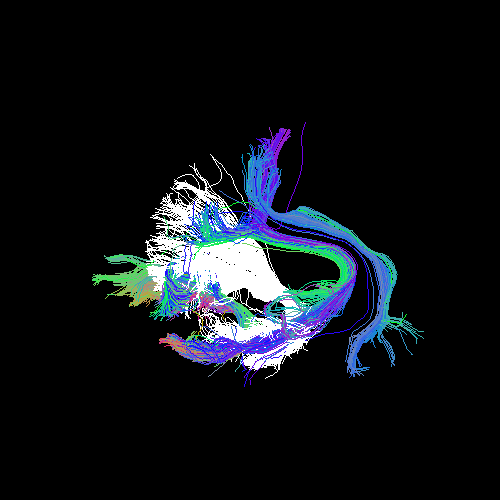

In [297]:
Image('pyAFQuicobundles_freesurfer_test_outputs/Left Uncinate_1tA.png')

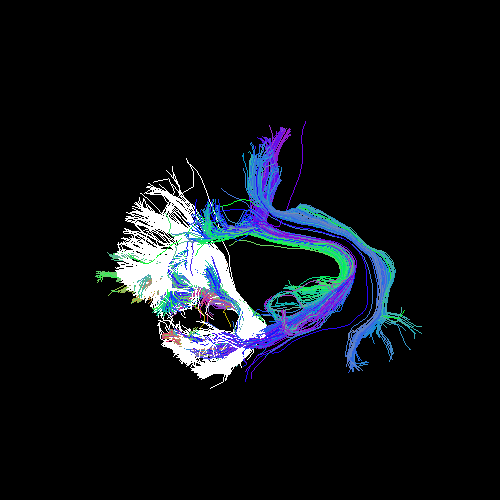

In [298]:
Image('pyAFQuicobundles_freesurfer_test_outputs/Left Uncinate_1tB.png')

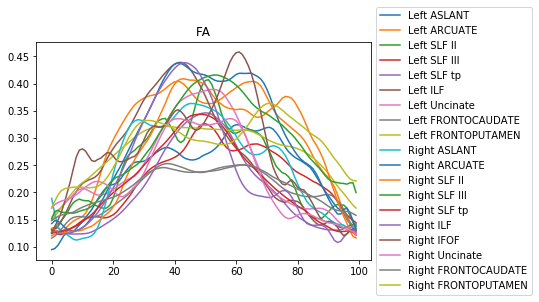

In [340]:
fig, ax = plt.subplots(1)
fa_df.plot(ax=ax, title='FA')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

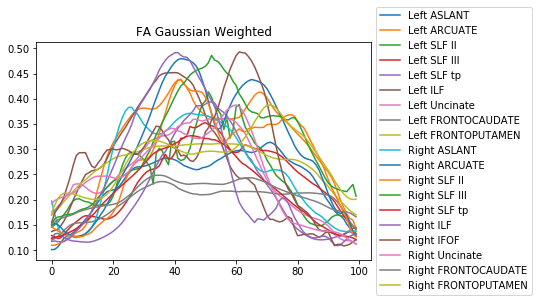

In [342]:
fig, ax = plt.subplots(1)
fa_df_gwt.plot(ax=ax, title='FA Gaussian Weighted')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))